In [1]:
import math
import torch
import random
import numpy as np
from torch import nn
import openmm.unit as unit
from scipy.constants import physical_constants
from src.utils.utils import *

import openmm as mm
from tqdm import tqdm
from openmm import app

/home/guest_sky/.conda/envs/tps/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = {
    'seed': 0,
    'device': 'cuda',
    'force': False,
    'bias_scale': 20000,
    'num_samples': 8,
    'learning_rate': 1e-3,
    'num_rollouts': 500,
    'trains_per_rollout': 2000,
    'buffer_size': 100,
    'max_grad_norm': 10,
    'target_std': 1,
    'num_steps': 500,
    'save_dir': 'results',
}

In [3]:
class AlanineDynamics:
    def __init__(self, state):
        super().__init__()
        self.start_file = f'./data/alanine/{state}.pdb'

        self.temperature = 300 * unit.kelvin
        self.friction_coefficient = 1 / unit.picoseconds
        self.timestep = 1 * unit.femtoseconds

        self.integrator, self.simulation, self.external_force = self.setup()

        self.simulation.minimizeEnergy()
        self.position = self.report()[0]
        self.reset()

        self.num_particles = self.simulation.system.getNumParticles()
        self.v_scale, self.f_scale, self.masses, self.std = self.get_md_info()

    def setup(self):
        forcefield = app.ForceField('amber99sbildn.xml')
        pdb = app.PDBFile(self.start_file)
        system = forcefield.createSystem(
            pdb.topology,
            nonbondedMethod=app.PME,
            nonbondedCutoff=1.0 * unit.nanometers,
            constraints=app.HBonds,
            ewaldErrorTolerance=0.0005
        )
        external_force = mm.CustomExternalForce("fx*x+fy*y+fz*z")

        # creating the parameters
        external_force.addPerParticleParameter("fx")
        external_force.addPerParticleParameter("fy")
        external_force.addPerParticleParameter("fz")
        system.addForce(external_force)
        for i in range(len(pdb.positions)):
            external_force.addParticle(i, [0, 0, 0])

        integrator = mm.LangevinIntegrator(
            self.temperature,  
            self.friction_coefficient,  
            self.timestep,
        ) 

        integrator.setConstraintTolerance(0.00001)

        simulation = app.Simulation(pdb.topology, system, integrator)
        simulation.context.setPositions(pdb.positions)

        return integrator, simulation, external_force

    def get_md_info(self):
        v_scale = np.exp(-self.timestep * self.friction_coefficient)
        f_scale = (1 - v_scale) / self.friction_coefficient

        masses = [self.simulation.system.getParticleMass(i).value_in_unit(unit.dalton) for i in range(self.num_particles)]
        masses = unit.Quantity(np.array(masses), unit.dalton)
        
        unadjusted_variance = unit.BOLTZMANN_CONSTANT_kB * self.temperature * (1 - v_scale ** 2) / masses[:, None]
        std_SI_units = 1 / physical_constants['unified atomic mass unit'][0] * unadjusted_variance.value_in_unit(unit.joule / unit.dalton)
        std = unit.Quantity(np.sqrt(std_SI_units), unit.meter / unit.second)
        return v_scale, f_scale, masses, std

    def step(self, forces):
        for i in range(forces.shape[0]):
            self.external_force.setParticleParameters(i, i, forces[i])
        self.external_force.updateParametersInContext(self.simulation.context)
        self.simulation.step(1)

    def report(self):
        state = self.simulation.context.getState(getPositions=True, getVelocities=True, getForces=True, getEnergy=True)
        positions = state.getPositions().value_in_unit(unit.nanometer)
        velocities = state.getVelocities().value_in_unit(unit.nanometer/unit.femtosecond)
        forces = state.getForces().value_in_unit(unit.kilojoules/unit.mole/unit.nanometer)
        potentials = state.getPotentialEnergy().value_in_unit(unit.kilojoules/unit.mole)
        return positions, velocities, forces, potentials

    def reset(self):
        for i in range(len(self.position)):
            self.external_force.setParticleParameters(i, i, [0, 0, 0])
        self.external_force.updateParametersInContext(self.simulation.context)
        self.simulation.context.setPositions(self.position)
        self.simulation.context.setVelocitiesToTemperature(0)

    def set_temperature(self, temperature):
        self.integrator.setTemperature(temperature * unit.kelvin)

class MDs:
    def __init__(self, args):
        self.device = args['device']
        self.num_samples = args['num_samples']

        self.mds = self._init_mds()
        self.target_position = self._init_target_position()

    def _init_mds(self):
        print(f"Initialize dynamics starting at c5 of alanine")

        mds = []
        for _ in tqdm(range(self.num_samples)):
            md = AlanineDynamics('c5')
            mds.append(md)
        return mds

    def _init_target_position(self):
        target_position = AlanineDynamics('c7ax').position
        target_position = torch.tensor(target_position, dtype=torch.float, device=self.device).unsqueeze(0)
        return target_position

    def step(self, force):
        force = force.detach().cpu().numpy()
        for i in range(self.num_samples):
            self.mds[i].step(force[i])

    def report(self):
        positions, velocities, forces, potentials = [], [], [], []
        for i in range(self.num_samples):
            position, velocity, force, potential = self.mds[i].report()
            positions.append(position); velocities.append(velocity); forces.append(force); potentials.append(potential)
            
        positions = torch.tensor(positions, dtype=torch.float, device=self.device)
        velocities = torch.tensor(velocities, dtype=torch.float, device=self.device)
        forces = torch.tensor(forces, dtype=torch.float, device=self.device)
        potentials = torch.tensor(potentials, dtype=torch.float, device=self.device)
        return positions, velocities, forces, potentials
    
    def reset(self):
        for i in range(self.num_samples):
            self.mds[i].reset()

    def set_temperature(self, temperature):
        for i in range(self.num_samples):
            self.mds[i].set_temperature(temperature)

In [4]:
class AlaninePolicy(nn.Module):
    def __init__(self, args, md):
        super().__init__()
        
        self.force = args['force']

        self.num_particles = md.num_particles
        self.input_dim = md.num_particles*3
        self.output_dim = md.num_particles*3 if self.force else 1

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim, bias=False)
        )

        self.log_z = nn.Parameter(torch.tensor(0.))

        self.to(args['device'])

    def forward(self, pos):
        if not self.force:
            pos.requires_grad = True
            
        out = self.mlp(pos.reshape(-1, self.input_dim))

        if not self.force:
            force = - torch.autograd.grad(out.sum(), pos, create_graph=True, retain_graph=True)[0]
        else:
            force = out.view(*pos.shape)
                
        return force    

In [14]:
class FlowNetAgent:
    def __init__(self, args, md):
        self.num_particles = md.num_particles
        self.v_scale = torch.tensor(md.v_scale, dtype=torch.float, device=args['device'])
        self.f_scale = torch.tensor(md.f_scale.value_in_unit(md.f_scale.unit), dtype=torch.float, device=args['device'])
        self.std = torch.tensor(md.std.value_in_unit(md.std.unit), dtype=torch.float, device=args['device'])
        self.masses = torch.tensor(md.masses.value_in_unit(md.masses.unit), dtype=torch.float, device=args['device']).unsqueeze(-1)

        self.policy = AlaninePolicy(args, md)

        self.replay = ReplayBuffer(args)

    def sample(self, args, mds):
        positions = torch.zeros((args['num_samples'], args['num_steps']+1, self.num_particles, 3), device=args['device'])
        actions = torch.zeros((args['num_samples'], args['num_steps'], self.num_particles, 3), device=args['device'])
        potentials = torch.zeros(args['num_samples'], args['num_steps']+1, device=args['device'])
        
        position, _, _, potential = mds.report()
        
        positions[:, 0] = position
        potentials[:, 0] = potential

        for s in tqdm(range(args['num_steps']), desc='Sampling'):
            bias = args['bias_scale'] * self.policy(position.detach()).squeeze().detach()
            mds.step(bias)
            
            next_position, velocity, force, potential = mds.report()

            # extract noise which openmm does not provide
            noises = (next_position - position) - (self.v_scale * velocity + self.f_scale * force / self.masses)
            action = self.f_scale * bias / self.masses + noises # TODO: 수치 찾기

            positions[:, s+1] = next_position
            actions[:, s] = action
            potentials[:, s+1] = potential - (bias*next_position).sum((-2, -1))

            position = next_position
        mds.reset()
        
        target_dist_matrix = get_dist_matrix(mds.target_position)

        dist_matrix = get_dist_matrix(positions[:, -1])
        last_idx = args['num_steps'] * torch.ones(args['num_samples'], dtype=torch.long, device=args['device'])
        log_target_reward = torch.square((dist_matrix-target_dist_matrix)).sum((1, 2))
        log_md_reward = torch.square(actions/self.std).sum((1, 2, 3))
        log_reward = log_md_reward + log_target_reward

        self.replay.add((positions, actions, log_reward))
        
        res = {
            'positions': positions, 
            'last_position': positions[torch.arange(args['num_samples']), last_idx],
            'target_position': mds.target_position,
            'potentials': potentials,
            'log_target_reward': log_target_reward,
            'log_md_reward': log_md_reward,
            'log_reward': log_reward,
            'last_idx': last_idx,
        }
        return res


    def train(self, args):
        policy_optimizers = torch.optim.SGD(self.policy.parameters(), lr=args['learning_rate'])

        positions, actions, log_reward = self.replay.sample()

        biases = args['bias_scale'] * self.policy(positions[:, :-1])
        biases = self.f_scale * biases / self.masses
        
        log_z = self.policy.log_z
        log_forward = torch.square((biases-actions)/self.std).sum((1, 2, 3))
        loss = torch.mean((log_z+log_forward-log_reward)**2)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), args['max_grad_norm'])
        
        policy_optimizers.step()
        policy_optimizers.zero_grad()
        return loss.item()

class ReplayBuffer:
    def __init__(self, args):
        self.buffer = []
        self.buffer_size = args['buffer_size']

    def add(self, data):
        self.buffer.append(data)
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)

    def sample(self):
        idx = random.randrange(len(self.buffer))
        return self.buffer[idx]

In [15]:
from src.utils.metrics import *
from src.utils.plot import *

def log(loss, policy, rollout, positions, last_position, target_position, potentials, log_target_reward, log_md_reward, log_reward, last_idx):
    epd = expected_pairwise_distance(last_position, target_position)
    thp = target_hit_percentage(last_position, target_position)
    etp = energy_transition_point(last_position, target_position, potentials, last_idx)
    nll = -log_md_reward.mean().item()

    torch.save(policy.state_dict(), f'{args["save_dir"]}/policy.pt')
    if rollout % 10 == 0:
        plot_paths_alanine(positions, target_position, last_idx)
        plot_potentials(args['save_dir'], rollout, potentials, log_target_reward, log_reward, last_idx)
        
    print(f"Rollout: {rollout}, Loss: {loss}, EPD: {epd}, THP: {thp}, ETP: {etp}, NLL: {nll}")

def plot(positions, target_position, potentials, log_target_reward, log_reward, last_idx, **kwargs):
    plot_potential(args['save_dir'], potentials, log_target_reward, log_reward, last_idx)
    plot_3D_view(args['save_dir'], './data/alanine/c5.pdb', positions, last_idx)
    plot_path(args['save_dir'], positions, target_position, last_idx)

Initialize dynamics starting at c5 of alanine


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 218.66it/s]


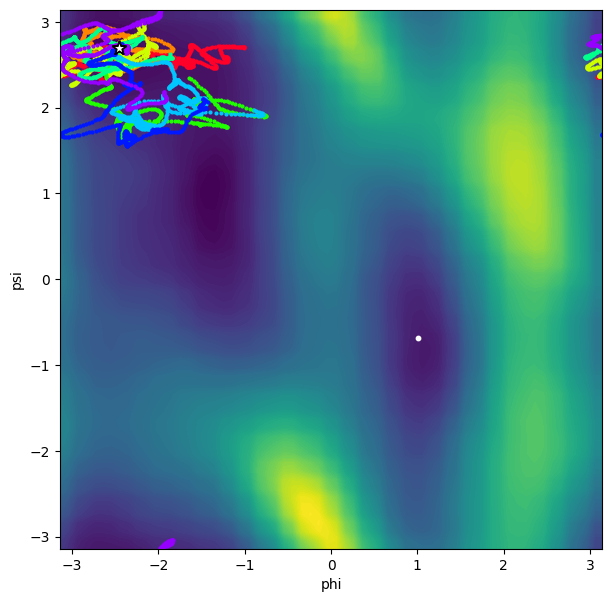

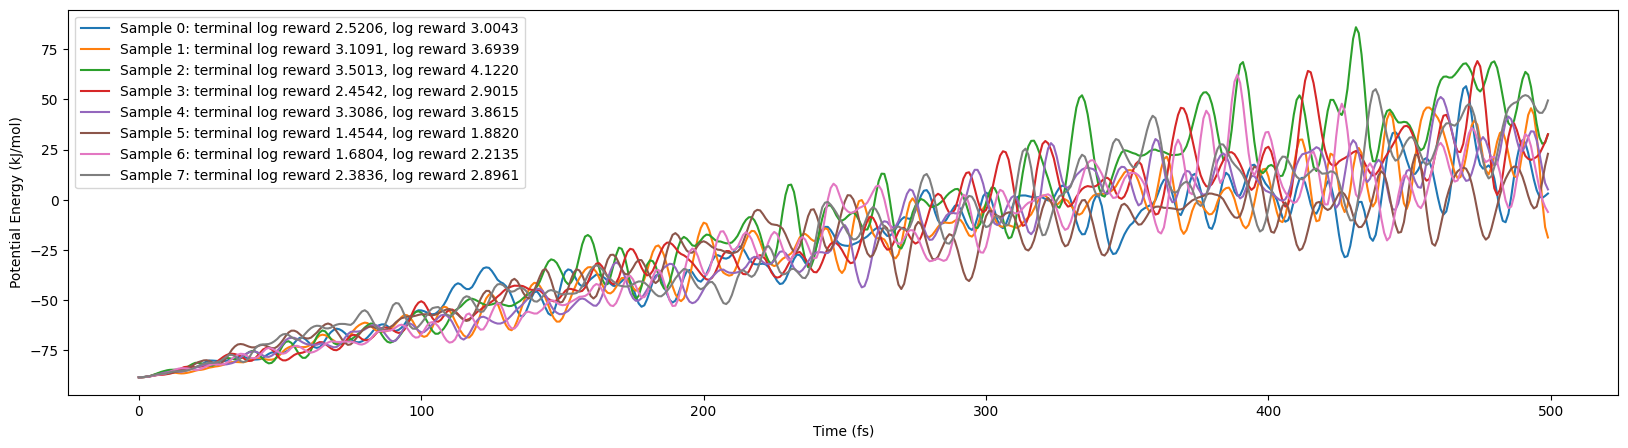

Rollout: 0, Loss: 1.2873212649822234, EPD: 5.271782632917166, THP: 0, ETP: None, NLL: -0.5203134417533875


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.70it/s]


Rollout: 1, Loss: 0.8388970556110144, EPD: 5.947001278400421, THP: 0, ETP: None, NLL: -0.5648370981216431


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.14it/s]


Rollout: 2, Loss: 0.9016724649816752, EPD: 4.104466177523136, THP: 0, ETP: None, NLL: -0.512500524520874


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 228.49it/s]


Rollout: 3, Loss: 0.8164674729853868, EPD: 3.3742350060492754, THP: 0, ETP: None, NLL: -0.5214585065841675


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.23it/s]


Rollout: 4, Loss: 0.7067506804913283, EPD: 3.740152344107628, THP: 0, ETP: None, NLL: -0.5245013236999512


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 238.59it/s]


Rollout: 5, Loss: 0.7561102434396744, EPD: 5.217363126575947, THP: 0, ETP: None, NLL: -0.7414525747299194


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 243.80it/s]


Rollout: 6, Loss: 0.8354566813856363, EPD: 5.879725329577923, THP: 25, ETP: 221.88087463378906, NLL: -0.8316737413406372


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 239.83it/s]


Rollout: 7, Loss: 0.802394411161542, EPD: 5.52140548825264, THP: 0, ETP: None, NLL: -0.6031012535095215


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 236.99it/s]


Rollout: 8, Loss: 0.76974927996099, EPD: 3.7444401532411575, THP: 0, ETP: None, NLL: -0.5403372049331665


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 235.78it/s]


Rollout: 9, Loss: 0.7000646471530199, EPD: 4.368081223219633, THP: 0, ETP: None, NLL: -0.5771266222000122


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 217.58it/s]


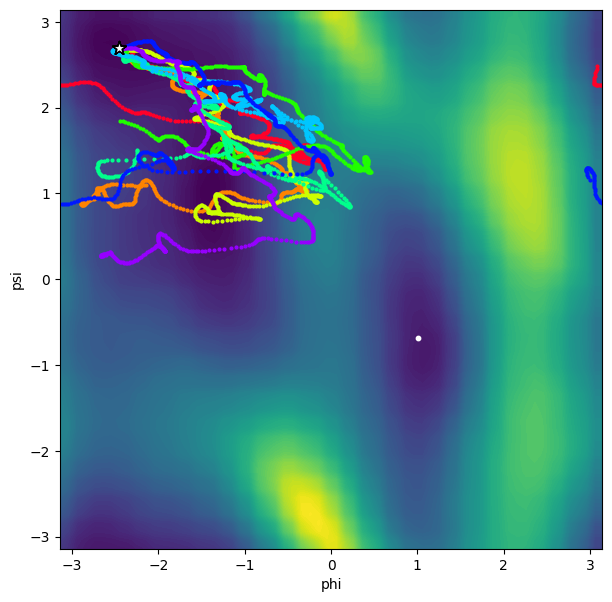

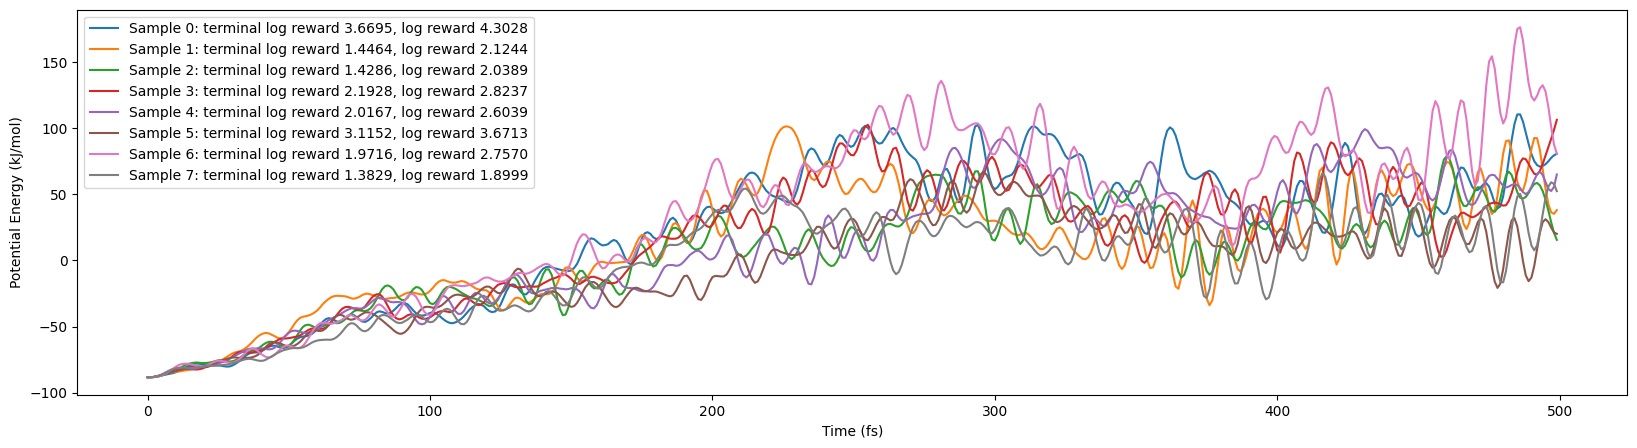

Rollout: 10, Loss: 0.6972077651098371, EPD: 4.44830534979701, THP: 0, ETP: None, NLL: -0.624754786491394


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 246.42it/s]


Rollout: 11, Loss: 0.6519099135100842, EPD: 5.485631059855223, THP: 0, ETP: None, NLL: -0.7174636125564575


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 232.23it/s]


Rollout: 12, Loss: 0.7498043002560735, EPD: 7.467222400009632, THP: 0, ETP: None, NLL: -1.016993522644043


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 241.43it/s]


Rollout: 13, Loss: 0.7475506376326084, EPD: 6.199578754603863, THP: 0, ETP: None, NLL: -0.6364188194274902


Sampling:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 273/500 [00:03<00:03, 57.18it/s]

In [ ]:
torch.manual_seed(args['seed'])

mds = MDs(args)
agent = FlowNetAgent(args, mds.mds[0])

mds.set_temperature(1500)
for rollout in range(args['num_rollouts']):    
    res = agent.sample(args, mds)

    loss = 0
    for _ in tqdm(range(args['trains_per_rollout']), desc='Training'):
        loss += agent.train(args)
    
    loss = loss / args['trains_per_rollout']

    log(loss, agent.policy, rollout, **res)
    
mds.set_temperature(300)
res = agent.sample(args, mds)
log(None, agent.policy, -10, **res)
plot(**res)